In [2]:
import numpy as np
import pandas as pd
import pyspark as ps
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
ratings = pd.read_csv('cleaned_data/ratings.csv')

In [150]:
len(ratings)

800000

In [172]:
ratings.loc[ratings['user']==6040]

,user,movie,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5
...,...,...,...
211467,6040,535,4
211468,6040,3751,4
211469,6040,495,2
211470,6040,1077,5


In [4]:
ratings.head()

,user,movie,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5


In [5]:
spark = SparkSession.builder.getOrCreate()
spark_df = spark.createDataFrame(ratings)

In [6]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=1)

In [152]:
train.distinct().count()

640665

In [122]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10)

In [123]:
recommender = als_model.fit(train)

In [124]:
p_ratings = recommender.transform(train)

In [125]:
p_ratings_df = p_ratings.toPandas()

In [126]:
p_ratings_df['squared_error'] = (p_ratings_df['rating'] - p_ratings_df['prediction'])**2

In [127]:
np.sqrt(p_ratings_df['squared_error'].mean())

0.8197275892046302

In [128]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [129]:
rmse = evaluator.evaluate(p_ratings)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8198278972812725


In [16]:
p_ratings.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
| 673|  148|     5| 3.8626866|
|4784|  148|     3|  2.840065|
|2383|  148|     2|   2.39018|
|1242|  148|     3| 3.1492693|
|3539|  148|     3|  2.792273|
|1605|  148|     2| 2.0399823|
|1150|  148|     2| 2.4502244|
|3829|  148|     2| 2.0268416|
|2456|  148|     2| 2.4977765|
|2507|  148|     4| 3.1705122|
+----+-----+------+----------+
only showing top 10 rows



In [11]:
itemfactors = recommender.itemFactors
userfactors = recommender.userFactors

In [18]:
user = userfactors.filter('id = 673').collect()
movie = itemfactors.filter('id = 148').collect()

In [19]:
user_vec = np.array(user[0][1])
item_vec = np.array(movie[0][1])
user_vec.dot(item_vec)

3.8626866392605264

In [130]:
prediction = recommender.transform(test)

In [21]:
prediction.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
|4227|  148|     2| 1.5799897|
|3184|  148|     4| 2.8290672|
|1069|  148|     2| 2.6959114|
|4858|  463|     3| 2.5466502|
|4040|  463|     1|  1.796684|
|3753|  463|     2|  2.626993|
|3808|  463|     3|  2.378176|
|3829|  463|     2|   1.90345|
|5614|  471|     5| 3.7531898|
|1699|  471|     5| 3.9752107|
+----+-----+------+----------+
only showing top 10 rows



In [23]:
prediction.describe().show()

+-------+------------------+------------------+------------------+----------+
|summary|              user|             movie|            rating|prediction|
+-------+------------------+------------------+------------------+----------+
|  count|            159335|            159335|            159335|    159335|
|   mean| 3404.643781968808|1850.0459032855306|3.5894436250666835|       NaN|
| stddev|1544.5439619295785| 1086.547829296142|1.1216084316255814|       NaN|
|    min|               636|                 1|                 1| 0.5218163|
|    max|              6040|              3952|                 5|       NaN|
+-------+------------------+------------------+------------------+----------+



In [131]:
predictions_df = prediction.toPandas()

In [132]:
predictions_df.head()

,user,movie,rating,prediction
0,4227,148,2,1.919962
1,3184,148,4,3.035991
2,1069,148,2,2.561747
3,4858,463,3,2.481914
4,4040,463,1,1.765732


In [133]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [29]:
predictions_df.head()

,user,movie,rating,prediction,squared_error
0,4227,148,2,1.579990,0.176409
1,3184,148,4,2.829067,1.371083
2,1069,148,2,2.695911,0.484293
3,4858,463,3,2.546650,0.205526
4,4040,463,1,1.796684,0.634705


In [134]:
np.sqrt(predictions_df['squared_error'].mean())

0.8760740296097116

In [136]:
rmse = evaluator.evaluate(prediction)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = nan


In [106]:
fake_test = pd.read_csv('data/fake_testing.csv', names=['user', 'movie', 'rating'])

In [107]:
spark_ftest = spark.createDataFrame(fake_test)

ft_transform = recommender.transform(spark_ftest)

In [120]:
ft_transform.show(50)

+----+-----+------------+----------+
|user|movie|actualrating|prediction|
+----+-----+------------+----------+
|  53|  148|           2|       NaN|
|4169|  148|           4| 3.0454652|
|5333|  148|           1| 2.2217238|
|4387|  148|           1| 2.0919197|
| 840|  148|           1| 2.8395712|
| 216|  148|           3|       NaN|
| 482|  148|           2|       NaN|
| 752|  148|           1| 2.9017036|
| 424|  148|           4|       NaN|
| 970|  463|           1| 2.8145456|
|4169|  463|           4| 2.3917847|
|  26|  463|           3|       NaN|
| 319|  463|           1|       NaN|
| 202|  463|           1|       NaN|
| 721|  463|           2| 3.2837703|
| 331|  463|           2|       NaN|
| 524|  463|           2|       NaN|
|1962|  463|           3| 2.0038242|
| 934|  463|           3| 2.2288504|
|1088|  471|           1| 3.3729396|
| 392|  471|           1|       NaN|
| 516|  471|           3|       NaN|
|1265|  471|           4|       NaN|
|4186|  471|           4| 2.8751643|
|

In [113]:
ft_transform_df = ft_transform.toPandas()

In [118]:
len(ft_transform_df)

200209

In [137]:
(ft_transform_df.isna()).sum()

user                0
movie               0
actualrating        0
prediction      95790
dtype: int64

In [145]:
ft_nan_users = ft_transform_df[['user','prediction']]

In [148]:
ft_nan_users = ft_nan_users[ft_nan_users['prediction'].isna()]

In [178]:
ft_nan_users.to_csv('cleaned_data/nan_users.csv')

In [119]:
ft_transform_df.head(50)

,user,movie,actualrating,prediction
0,53,148,2,NaN
1,4169,148,4,3.045465
2,5333,148,1,2.221724
3,4387,148,1,2.091920
4,840,148,1,2.839571
5,216,148,3,NaN
6,482,148,2,NaN
7,752,148,1,2.901704
8,424,148,4,NaN
9,970,463,1,2.814546


In [160]:
fake_test2 = pd.read_csv('data/fake_testing.csv')

In [162]:
fake_test2['rating'] = fake_test2['actualrating']

In [163]:
fake_test2.drop(labels='actualrating', axis=1, inplace=True)


In [164]:
spark_ftest2 = spark.createDataFrame(fake_test2)

ft_transform2 = recommender.transform(spark_ftest2)

In [165]:
ft_transform2.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
|  53|  148|     2|       NaN|
|4169|  148|     4| 3.0454652|
|5333|  148|     1| 2.2217238|
|4387|  148|     1| 2.0919197|
| 840|  148|     1| 2.8395712|
| 216|  148|     3|       NaN|
| 482|  148|     2|       NaN|
| 752|  148|     1| 2.9017036|
| 424|  148|     4|       NaN|
| 970|  463|     1| 2.8145456|
+----+-----+------+----------+
only showing top 10 rows



In [114]:
# rmse = evaluator.evaluate(ft_transform)
# print("Root-mean-square error = " + str(rmse))

## Plotting

/opt/conda/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


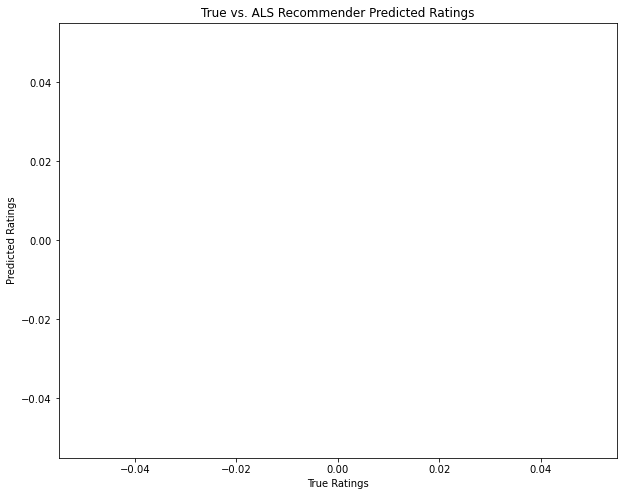

In [138]:
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]

fig, ax = plt.subplots(figsize=(10,8))

ax.violinplot(data, range(1,6), showmeans=False)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [46]:
len(data)

5

(array([1.08192e+05, 2.67550e+04, 1.19400e+04, 5.65000e+03, 2.89300e+03,
        1.54300e+03, 9.27000e+02, 5.27000e+02, 3.52000e+02, 1.80000e+02,
        1.33000e+02, 8.40000e+01, 5.20000e+01, 2.50000e+01, 1.40000e+01,
        1.20000e+01, 7.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00]),
 array([9.0949470e-13, 7.7161729e-01, 1.5432346e+00, 2.3148518e+00,
        3.0864692e+00, 3.8580863e+00, 4.6297035e+00, 5.4013209e+00,
        6.1729383e+00, 6.9445553e+00, 7.7161727e+00, 8.4877901e+00,
        9.2594070e+00, 1.0031025e+01, 1.0802642e+01, 1.1574259e+01,
        1.2345877e+01, 1.3117494e+01, 1.3889111e+01, 1.4660728e+01,
        1.5432345e+01], dtype=float32),
 <a list of 20 Patch objects>)

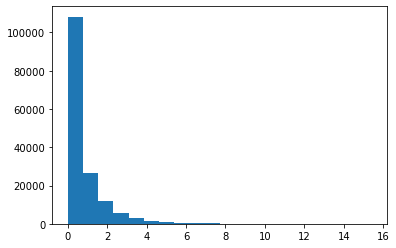

In [53]:
plt.hist(predictions_df['squared_error'], bins=20)

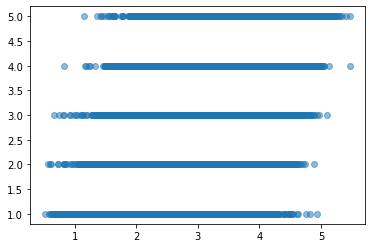

In [52]:
plt.scatter(predictions_df['prediction'],predictions_df['rating'], alpha=.5)

## Understanding Latent Features 

In [15]:
itemfactors_df = itemfactors.toPandas()

In [22]:
(itemfactors_df['features'].values).shape

(3625,)

In [78]:
sorted_items = itemfactors_df.sort_values(by='id')

In [79]:
sorted_items.set_index(keys='id', inplace=True)

In [95]:
sorted_items.values[0][0]

[0.7208385467529297,
 0.08985200524330139,
 0.04785703867673874,
 0.03187407925724983,
 0.7748639583587646,
 0.4837433695793152,
 0.7918107509613037,
 0.9629693627357483,
 0.5698899626731873,
 0.17187771201133728]

In [93]:
matrix = np.zeros([3625,10])

for x in sorted_items.values:
    for i, y in emumerate(x):
        matrix[i,:]

TypeError: data type not understood

In [173]:
sorted_items['features'].values

array([list([0.7208385467529297, 0.08985200524330139, 0.04785703867673874, 0.03187407925724983, 0.7748639583587646, 0.4837433695793152, 0.7918107509613037, 0.9629693627357483, 0.5698899626731873, 0.17187771201133728]),
       list([0.55461585521698, 0.13874153792858124, 0.23370984196662903, 0.21228328347206116, 0.28509384393692017, 0.2697572112083435, 0.24621392786502838, 0.9610529541969299, 0.29356998205184937, 0.5274598002433777]),
       list([0.3442586660385132, 0.29780685901641846, 0.41779056191444397, 0.0, 0.2780248522758484, 0.20978949964046478, 0.44229045510292053, 0.8094544410705566, 0.14861492812633514, 0.8452003598213196]),
       ...,
       list([0.36412936449050903, 0.0, 0.0, 0.27478206157684326, 0.0, 0.35249966382980347, 0.6803697347640991, 1.5678869485855103, 0.32851630449295044, 0.0]),
       list([0.0, 0.5115406513214111, 0.0, 0.08775965869426727, 0.5238903760910034, 0.9095404744148254, 0.5656226873397827, 1.025285005569458, 0.5756511688232422, 0.29113858938217163]),


In [177]:
pd.DataFrame(sorted_items['features'].values)

,0
0,"[0.7208385467529297, 0.08985200524330139, 0.04..."
1,"[0.55461585521698, 0.13874153792858124, 0.2337..."
2,"[0.3442586660385132, 0.29780685901641846, 0.41..."
3,"[0.2476443499326706, 0.09107796847820282, 0.29..."
4,"[0.34001076221466064, 0.0063025932759046555, 0..."
...,...
3620,"[0.3921753466129303, 0.015468445606529713, 0.7..."
3621,"[0.2906750440597534, 0.0, 0.6350924968719482, ..."
3622,"[0.36412936449050903, 0.0, 0.0, 0.274782061576..."
3623,"[0.0, 0.5115406513214111, 0.0, 0.0877596586942..."


In [89]:
sorted_items.

array([list([0.7208385467529297, 0.08985200524330139, 0.04785703867673874, 0.03187407925724983, 0.7748639583587646, 0.4837433695793152, 0.7918107509613037, 0.9629693627357483, 0.5698899626731873, 0.17187771201133728])],
      dtype=object)

In [58]:
np.array(sorted_items['features']

(10,)

In [23]:
userfactors_df = userfactors.toPandas()

In [25]:
(userfactors_df['features'].values).


(5399,)

In [30]:
userfactors_df['features'].values[0]

[0.6564563512802124,
 0.682487964630127,
 0.7633579969406128,
 0.6249393820762634,
 0.48795026540756226,
 0.8060238361358643,
 0.9950987100601196,
 1.3105900287628174,
 1.3464887142181396,
 0.7762758731842041]

In [31]:
userfactors_df

,id,features
0,640,"[0.6564563512802124, 0.682487964630127, 0.7633..."
1,650,"[0.7669003009796143, 0.18694300949573517, 0.41..."
2,660,"[0.5475112199783325, 0.7113644480705261, 0.285..."
3,670,"[0.6252161860466003, 0.6471410393714905, 0.211..."
4,680,"[0.7640587687492371, 0.45688655972480774, 0.21..."


## User Subset

In [52]:
recommender.recommendForItemSubset(train, 10).show()

+-----+--------------------+
|movie|     recommendations|
+-----+--------------------+
|  463|[[3113, 4.609388]...|
| 1591|[[3902, 4.194338]...|
| 3918|[[2867, 4.469325]...|
| 3175|[[3902, 4.89802],...|
|  496|[[932, 4.7633276]...|
| 1238|[[1371, 4.8083806...|
| 3794|[[3545, 4.860028]...|
| 1342|[[2155, 4.607645]...|
|  833|[[3902, 4.076675]...|
| 2366|[[2755, 4.703263]...|
| 1829|[[2694, 3.7814484...|
|  471|[[692, 4.4713182]...|
| 1959|[[4900, 4.6678233...|
| 1580|[[3902, 5.0550857...|
| 2142|[[3902, 4.1652203...|
| 2659|[[3902, 4.536792]...|
| 2866|[[2339, 4.4895797...|
| 1088|[[4778, 4.936863]...|
| 2122|[[2155, 4.9339128...|
| 1645|[[3902, 5.0015507...|
+-----+--------------------+
only showing top 20 rows



In [53]:
recommender.recommendForUserSubset(train, 10).show()

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|4519|[[811, 5.669782],...|
|4935|[[3906, 5.214474]...|
|1591|[[557, 5.9289923]...|
|3918|[[3906, 5.026055]...|
|3175|[[3906, 5.815897]...|
|4900|[[572, 5.9214687]...|
|1238|[[557, 5.2848577]...|
|3794|[[2309, 4.4060407...|
|1342|[[572, 4.5137315]...|
| 833|[[572, 5.4476247]...|
|2366|[[572, 4.6917243]...|
|5803|[[97, 4.5318174],...|
|1829|[[3906, 5.228789]...|
|4101|[[2086, 4.929735]...|
|5518|[[557, 5.3904967]...|
|1959|[[572, 5.5938325]...|
|1580|[[557, 4.591143],...|
|2142|[[572, 4.8600545]...|
|5300|[[3906, 5.5257773...|
|2659|[[3906, 5.4109], ...|
+----+--------------------+
only showing top 20 rows

